In [1]:
import endomill
import yaml


In [2]:
parameter_packs = [
    {
        "MILL_FITNESS_ADVANTAGE": fitness_advantage,
        "MILL_REPLICATE": replicate,
    }
    for replicate in range(10)
    for fitness_advantage in [0.0, 0.1, 1.0]
]

for i, pp in enumerate(parameter_packs):
    with open(
        f"gene-selection-inference-parameterization-{i}.yaml", "w"
    ) as file:
        yaml.safe_dump(pp, file)
# endomill.instantiate_over(parameter_packs=parameter_packs)


# Papermill Parameters


In [3]:
MILL_FITNESS_ADVANTAGE: float
MILL_REPLICATE: int


In [4]:
# Parameters
MILL_FITNESS_ADVANTAGE = 0.1
MILL_REPLICATE = 3


In [5]:
import copy
import random

import alifedata_phyloinformatics_convert as apc
from deap import algorithms as deap_algorithms
from deap import base as deap_base
from deap import creator as deap_creator
from deap import tools as deap_tools
from hstrat import hstrat
from keyname import keyname as kn
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

import pylib


In [6]:
random.seed(MILL_REPLICATE)


# Parameters


In [7]:
HSTRAT_RESOLUTION = 1000
HSTRAT_DIFFERENTIA_WIDTH = 64

TOURNAMENT_SIZE = 2

NGEN = 200

POPULATION_SIZE = 400


# Setup


In [8]:
deap_creator.create("FitnessMax", deap_base.Fitness, weights=(1.0,))
deap_creator.create("Individual", list, fitness=deap_creator.FitnessMax)

toolbox = deap_base.Toolbox()

toolbox.register(
    "individual",
    lambda *args, **kwargs: deap_creator.Individual([0.0]),
    deap_creator.Individual,
    n=1,
)
toolbox.register("population", deap_tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    return (individual[0] + random.random(),)


toolbox.register("evaluate", evalOneMax)
# hack to ensure gene annotation remains associated with gene
toolbox.register("mate", lambda x, y: random.choice([(x, y), (y, x)]))
toolbox.register("mutate", lambda x: tuple(x))
toolbox.register("select", deap_tools.selTournament, tournsize=TOURNAMENT_SIZE)

# Decorate the variation operators
toolbox.decorate("mate", pylib.deap.hstrat_mate_decorator)


# Evolve


In [9]:
# Create the population and populate the history
population = toolbox.population(n=POPULATION_SIZE)

species_ancestor = hstrat.HereditaryStratigraphicColumn(
    stratum_retention_policy=hstrat.nominal_resolution_algo.Policy(),
    stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
)
for member in population:
    member.species_annotation = species_ancestor.CloneDescendant()
    member.gene_annotation = hstrat.HereditaryStratigraphicColumn(
        stratum_retention_policy=hstrat.perfect_resolution_algo.Policy(),
        stratum_differentia_bit_width=HSTRAT_DIFFERENTIA_WIDTH,
        initial_stratum_annotation=0,
    ).CloneDescendant(0)


# Do the evolution, the decorators will take care of updating the
# history
prevalences = []
for gen in tqdm(range(NGEN)):
    prevalences.append(sum(1 for x in population if x[0] > 0))

    offspring = deap_algorithms.varAnd(
        population, toolbox, cxpb=1.0, mutpb=0.0
    )
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    population = [copy.deepcopy(ind) for ind in population]

    if gen >= NGEN // 4:
        if prevalences[-1] == 0:
            population[0][0] = MILL_FITNESS_ADVANTAGE



  0%|                                                                                                                                                                 | 0/200 [00:00<?, ?it/s]

  0%|▊                                                                                                                                                        | 1/200 [00:01<06:31,  1.97s/it]

  1%|█▌                                                                                                                                                       | 2/200 [00:03<05:36,  1.70s/it]

  2%|██▎                                                                                                                                                      | 3/200 [00:04<04:38,  1.42s/it]

  2%|███                                                                                                                                                      | 4/200 [00:06<04:50,  1.48s/it]

  2%|███▊                                                                                                                                                     | 5/200 [00:07<05:01,  1.55s/it]

  3%|████▌                                                                                                                                                    | 6/200 [00:09<05:28,  1.69s/it]

  4%|█████▎                                                                                                                                                   | 7/200 [00:11<05:08,  1.60s/it]

  4%|██████                                                                                                                                                   | 8/200 [00:12<04:59,  1.56s/it]

  4%|██████▉                                                                                                                                                  | 9/200 [00:14<05:13,  1.64s/it]

  5%|███████▌                                                                                                                                                | 10/200 [00:16<05:51,  1.85s/it]

  6%|████████▎                                                                                                                                               | 11/200 [00:18<05:55,  1.88s/it]

  6%|█████████                                                                                                                                               | 12/200 [00:20<05:48,  1.85s/it]

  6%|█████████▉                                                                                                                                              | 13/200 [00:22<05:42,  1.83s/it]

  7%|██████████▋                                                                                                                                             | 14/200 [00:23<05:30,  1.78s/it]

  8%|███████████▍                                                                                                                                            | 15/200 [00:25<05:41,  1.85s/it]

  8%|████████████▏                                                                                                                                           | 16/200 [00:27<05:27,  1.78s/it]

  8%|████████████▉                                                                                                                                           | 17/200 [00:29<05:41,  1.86s/it]

  9%|█████████████▋                                                                                                                                          | 18/200 [00:31<05:46,  1.90s/it]

 10%|██████████████▍                                                                                                                                         | 19/200 [00:34<06:27,  2.14s/it]

 10%|███████████████▏                                                                                                                                        | 20/200 [00:36<06:35,  2.20s/it]

 10%|███████████████▉                                                                                                                                        | 21/200 [00:39<07:20,  2.46s/it]

 11%|████████████████▋                                                                                                                                       | 22/200 [00:42<07:34,  2.55s/it]

 12%|█████████████████▍                                                                                                                                      | 23/200 [00:45<07:40,  2.60s/it]

 12%|██████████████████▏                                                                                                                                     | 24/200 [00:47<07:38,  2.60s/it]

 12%|███████████████████                                                                                                                                     | 25/200 [00:50<07:24,  2.54s/it]

 13%|███████████████████▊                                                                                                                                    | 26/200 [00:53<07:48,  2.69s/it]

 14%|████████████████████▌                                                                                                                                   | 27/200 [00:55<07:25,  2.58s/it]

 14%|█████████████████████▎                                                                                                                                  | 28/200 [00:58<07:45,  2.71s/it]

 14%|██████████████████████                                                                                                                                  | 29/200 [01:02<08:27,  2.97s/it]

 15%|██████████████████████▊                                                                                                                                 | 30/200 [01:04<08:12,  2.89s/it]

 16%|███████████████████████▌                                                                                                                                | 31/200 [01:07<07:49,  2.78s/it]

 16%|████████████████████████▎                                                                                                                               | 32/200 [01:10<07:49,  2.79s/it]

 16%|█████████████████████████                                                                                                                               | 33/200 [01:13<07:53,  2.84s/it]

 17%|█████████████████████████▊                                                                                                                              | 34/200 [01:16<07:59,  2.89s/it]

 18%|██████████████████████████▌                                                                                                                             | 35/200 [01:19<08:40,  3.15s/it]

 18%|███████████████████████████▎                                                                                                                            | 36/200 [01:23<08:35,  3.14s/it]

 18%|████████████████████████████                                                                                                                            | 37/200 [01:26<08:32,  3.15s/it]

 19%|████████████████████████████▉                                                                                                                           | 38/200 [01:29<08:37,  3.19s/it]

 20%|█████████████████████████████▋                                                                                                                          | 39/200 [01:32<08:05,  3.02s/it]

 20%|██████████████████████████████▍                                                                                                                         | 40/200 [01:35<07:58,  2.99s/it]

 20%|███████████████████████████████▏                                                                                                                        | 41/200 [01:37<07:48,  2.94s/it]

 21%|███████████████████████████████▉                                                                                                                        | 42/200 [01:40<07:50,  2.98s/it]

 22%|████████████████████████████████▋                                                                                                                       | 43/200 [01:44<08:12,  3.14s/it]

 22%|█████████████████████████████████▍                                                                                                                      | 44/200 [01:47<07:53,  3.04s/it]

 22%|██████████████████████████████████▏                                                                                                                     | 45/200 [01:50<08:02,  3.11s/it]

 23%|██████████████████████████████████▉                                                                                                                     | 46/200 [01:53<07:54,  3.08s/it]

 24%|███████████████████████████████████▋                                                                                                                    | 47/200 [01:57<08:42,  3.41s/it]

 24%|████████████████████████████████████▍                                                                                                                   | 48/200 [02:01<09:02,  3.57s/it]

 24%|█████████████████████████████████████▏                                                                                                                  | 49/200 [02:06<09:43,  3.86s/it]

 25%|██████████████████████████████████████                                                                                                                  | 50/200 [02:10<09:40,  3.87s/it]

 26%|██████████████████████████████████████▊                                                                                                                 | 51/200 [02:13<09:28,  3.81s/it]

 26%|███████████████████████████████████████▌                                                                                                                | 52/200 [02:16<08:53,  3.60s/it]

 26%|████████████████████████████████████████▎                                                                                                               | 53/200 [02:21<09:12,  3.76s/it]

 27%|█████████████████████████████████████████                                                                                                               | 54/200 [02:24<08:56,  3.67s/it]

 28%|█████████████████████████████████████████▊                                                                                                              | 55/200 [02:28<08:57,  3.71s/it]

 28%|██████████████████████████████████████████▌                                                                                                             | 56/200 [02:32<09:03,  3.78s/it]

 28%|███████████████████████████████████████████▎                                                                                                            | 57/200 [02:36<09:02,  3.79s/it]

 29%|████████████████████████████████████████████                                                                                                            | 58/200 [02:40<09:07,  3.86s/it]

 30%|████████████████████████████████████████████▊                                                                                                           | 59/200 [02:43<08:43,  3.71s/it]

 30%|█████████████████████████████████████████████▌                                                                                                          | 60/200 [02:47<09:14,  3.96s/it]

 30%|██████████████████████████████████████████████▎                                                                                                         | 61/200 [02:51<09:01,  3.89s/it]

 31%|███████████████████████████████████████████████                                                                                                         | 62/200 [02:55<08:54,  3.87s/it]

 32%|███████████████████████████████████████████████▉                                                                                                        | 63/200 [02:59<08:44,  3.83s/it]

 32%|████████████████████████████████████████████████▋                                                                                                       | 64/200 [03:04<09:22,  4.13s/it]

 32%|█████████████████████████████████████████████████▍                                                                                                      | 65/200 [03:08<09:17,  4.13s/it]

 33%|██████████████████████████████████████████████████▏                                                                                                     | 66/200 [03:13<09:54,  4.43s/it]

 34%|██████████████████████████████████████████████████▉                                                                                                     | 67/200 [03:18<10:17,  4.64s/it]

 34%|███████████████████████████████████████████████████▋                                                                                                    | 68/200 [03:22<09:53,  4.49s/it]

 34%|████████████████████████████████████████████████████▍                                                                                                   | 69/200 [03:27<09:52,  4.53s/it]

 35%|█████████████████████████████████████████████████████▏                                                                                                  | 70/200 [03:31<09:31,  4.39s/it]

 36%|█████████████████████████████████████████████████████▉                                                                                                  | 71/200 [03:36<09:42,  4.52s/it]

 36%|██████████████████████████████████████████████████████▋                                                                                                 | 72/200 [03:40<09:24,  4.41s/it]

 36%|███████████████████████████████████████████████████████▍                                                                                                | 73/200 [03:43<08:33,  4.05s/it]

 37%|████████████████████████████████████████████████████████▏                                                                                               | 74/200 [03:50<10:09,  4.83s/it]

 38%|█████████████████████████████████████████████████████████                                                                                               | 75/200 [03:55<10:21,  4.97s/it]

 38%|█████████████████████████████████████████████████████████▊                                                                                              | 76/200 [04:00<10:21,  5.01s/it]

 38%|██████████████████████████████████████████████████████████▌                                                                                             | 77/200 [04:06<10:42,  5.23s/it]

 39%|███████████████████████████████████████████████████████████▎                                                                                            | 78/200 [04:12<11:17,  5.56s/it]

 40%|████████████████████████████████████████████████████████████                                                                                            | 79/200 [04:18<11:10,  5.54s/it]

 40%|████████████████████████████████████████████████████████████▊                                                                                           | 80/200 [04:24<11:45,  5.88s/it]

 40%|█████████████████████████████████████████████████████████████▌                                                                                          | 81/200 [04:29<11:06,  5.60s/it]

 41%|██████████████████████████████████████████████████████████████▎                                                                                         | 82/200 [04:33<10:07,  5.15s/it]

 42%|███████████████████████████████████████████████████████████████                                                                                         | 83/200 [04:39<10:03,  5.16s/it]

 42%|███████████████████████████████████████████████████████████████▊                                                                                        | 84/200 [04:43<09:50,  5.09s/it]

 42%|████████████████████████████████████████████████████████████████▌                                                                                       | 85/200 [04:48<09:41,  5.06s/it]

 43%|█████████████████████████████████████████████████████████████████▎                                                                                      | 86/200 [04:55<10:11,  5.36s/it]

 44%|██████████████████████████████████████████████████████████████████                                                                                      | 87/200 [05:00<09:56,  5.28s/it]

 44%|██████████████████████████████████████████████████████████████████▉                                                                                     | 88/200 [05:04<09:24,  5.04s/it]

 44%|███████████████████████████████████████████████████████████████████▋                                                                                    | 89/200 [05:08<08:57,  4.84s/it]

 45%|████████████████████████████████████████████████████████████████████▍                                                                                   | 90/200 [05:13<08:52,  4.84s/it]

 46%|█████████████████████████████████████████████████████████████████████▏                                                                                  | 91/200 [05:19<09:04,  5.00s/it]

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                  | 92/200 [05:23<08:51,  4.92s/it]

 46%|██████████████████████████████████████████████████████████████████████▋                                                                                 | 93/200 [05:31<10:01,  5.62s/it]

 47%|███████████████████████████████████████████████████████████████████████▍                                                                                | 94/200 [05:36<09:57,  5.63s/it]

 48%|████████████████████████████████████████████████████████████████████████▏                                                                               | 95/200 [05:42<09:39,  5.52s/it]

 48%|████████████████████████████████████████████████████████████████████████▉                                                                               | 96/200 [05:46<09:08,  5.27s/it]

 48%|█████████████████████████████████████████████████████████████████████████▋                                                                              | 97/200 [05:52<09:12,  5.36s/it]

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                             | 98/200 [05:58<09:23,  5.53s/it]

 50%|███████████████████████████████████████████████████████████████████████████▏                                                                            | 99/200 [06:02<08:44,  5.19s/it]

 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 100/200 [06:07<08:36,  5.16s/it]

 50%|████████████████████████████████████████████████████████████████████████████▎                                                                          | 101/200 [06:12<08:26,  5.12s/it]

 51%|█████████████████████████████████████████████████████████████████████████████                                                                          | 102/200 [06:20<09:25,  5.77s/it]

 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 103/200 [06:25<09:16,  5.74s/it]

 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                        | 104/200 [06:30<08:56,  5.59s/it]

 52%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 105/200 [06:37<09:07,  5.76s/it]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 106/200 [06:43<09:09,  5.84s/it]

 54%|████████████████████████████████████████████████████████████████████████████████▊                                                                      | 107/200 [06:50<09:33,  6.17s/it]

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 108/200 [06:56<09:27,  6.17s/it]

 55%|██████████████████████████████████████████████████████████████████████████████████▎                                                                    | 109/200 [07:02<09:14,  6.09s/it]

 55%|███████████████████████████████████████████████████████████████████████████████████                                                                    | 110/200 [07:08<09:12,  6.14s/it]

 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 111/200 [07:14<09:01,  6.09s/it]

 56%|████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 112/200 [07:19<08:38,  5.89s/it]

 56%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 113/200 [07:26<08:44,  6.03s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 114/200 [07:31<08:25,  5.88s/it]

 57%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                | 115/200 [07:37<08:14,  5.81s/it]

 58%|███████████████████████████████████████████████████████████████████████████████████████▌                                                               | 116/200 [07:44<08:33,  6.12s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 117/200 [07:50<08:33,  6.19s/it]

 59%|█████████████████████████████████████████████████████████████████████████████████████████                                                              | 118/200 [07:56<08:29,  6.21s/it]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 119/200 [08:02<08:08,  6.02s/it]

 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 120/200 [08:08<08:13,  6.17s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 121/200 [08:14<08:03,  6.12s/it]

 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                           | 122/200 [08:19<07:31,  5.78s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 123/200 [08:25<07:24,  5.77s/it]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 124/200 [08:33<08:04,  6.38s/it]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 125/200 [08:39<07:59,  6.39s/it]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 126/200 [08:46<08:04,  6.54s/it]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 127/200 [08:53<08:08,  6.69s/it]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 128/200 [09:00<07:59,  6.66s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 129/200 [09:07<07:55,  6.70s/it]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 130/200 [09:13<07:49,  6.71s/it]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 131/200 [09:20<07:30,  6.53s/it]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 132/200 [09:26<07:20,  6.48s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 133/200 [09:32<07:04,  6.34s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 134/200 [09:38<07:02,  6.40s/it]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 135/200 [09:46<07:09,  6.60s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 136/200 [09:51<06:45,  6.34s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 137/200 [09:57<06:36,  6.30s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 138/200 [10:06<07:04,  6.84s/it]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 139/200 [10:12<06:42,  6.60s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 140/200 [10:19<06:42,  6.70s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 141/200 [10:25<06:34,  6.69s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 142/200 [10:32<06:31,  6.74s/it]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 143/200 [10:39<06:22,  6.71s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 144/200 [10:45<06:16,  6.71s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 145/200 [10:53<06:28,  7.06s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 146/200 [10:59<06:06,  6.79s/it]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 147/200 [11:07<06:04,  6.87s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 148/200 [11:16<06:31,  7.53s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 149/200 [11:24<06:32,  7.70s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 150/200 [11:31<06:20,  7.61s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 151/200 [11:37<05:52,  7.18s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 152/200 [11:46<06:03,  7.57s/it]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 153/200 [11:52<05:33,  7.09s/it]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 154/200 [11:59<05:33,  7.24s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 155/200 [12:07<05:31,  7.37s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 156/200 [12:14<05:25,  7.41s/it]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 157/200 [12:21<05:13,  7.28s/it]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 158/200 [12:29<05:03,  7.22s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 159/200 [12:35<04:49,  7.06s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 160/200 [12:43<04:51,  7.30s/it]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 161/200 [12:51<04:48,  7.39s/it]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 162/200 [12:58<04:38,  7.32s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 163/200 [13:05<04:33,  7.39s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 164/200 [13:12<04:22,  7.30s/it]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 165/200 [13:20<04:20,  7.43s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 166/200 [13:29<04:26,  7.83s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 167/200 [13:36<04:15,  7.74s/it]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 168/200 [13:44<04:02,  7.57s/it]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 169/200 [13:51<03:50,  7.43s/it]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 170/200 [13:58<03:43,  7.44s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 171/200 [14:06<03:42,  7.67s/it]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 172/200 [14:15<03:44,  8.01s/it]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 173/200 [14:23<03:35,  7.97s/it]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 174/200 [14:31<03:29,  8.04s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 175/200 [14:38<03:14,  7.77s/it]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 176/200 [14:46<03:03,  7.65s/it]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 177/200 [14:53<02:54,  7.61s/it]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 178/200 [15:01<02:47,  7.62s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 179/200 [15:10<02:46,  7.93s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 180/200 [15:19<02:45,  8.29s/it]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 181/200 [15:27<02:34,  8.14s/it]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 182/200 [15:35<02:27,  8.22s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 183/200 [15:42<02:15,  7.96s/it]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 184/200 [15:50<02:08,  8.02s/it]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 185/200 [15:59<02:01,  8.12s/it]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 186/200 [16:07<01:52,  8.07s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 187/200 [16:15<01:45,  8.10s/it]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 188/200 [16:23<01:38,  8.21s/it]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 189/200 [16:32<01:30,  8.25s/it]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 190/200 [16:42<01:27,  8.72s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 191/200 [16:50<01:17,  8.64s/it]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 192/200 [16:59<01:08,  8.62s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 193/200 [17:07<01:00,  8.64s/it]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 194/200 [17:15<00:49,  8.26s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 195/200 [17:23<00:41,  8.33s/it]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 196/200 [17:32<00:34,  8.56s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 197/200 [17:41<00:25,  8.50s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 198/200 [17:49<00:17,  8.52s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 199/200 [18:00<00:09,  9.10s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:10<00:00,  9.34s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [18:10<00:00,  5.45s/it]

# Visualization


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=3+viz=plot-sweep-and-annotations+ext=.pdf


teeplots/./fitness-advantage=0.1+notebook=gene-selection-inference+replicate=3+viz=plot-sweep-and-annotations+ext=.png


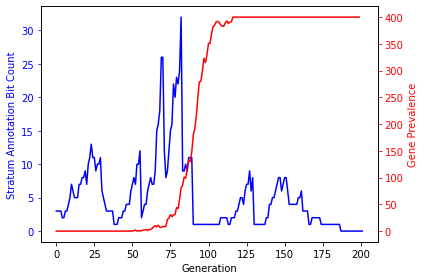

In [10]:
annotations = [
    s.GetAnnotation().bit_count()
    for s in population[0].gene_annotation.IterRetainedStrata()
]


def plot_sweep_and_annotations():
    # Create a figure and a single subplot
    fig, ax1 = plt.subplots()

    # Make the first plot on ax1
    sns.lineplot(data=annotations, color="b", ax=ax1)
    ax1.set_ylabel("Stratum Annotation Bit Count", color="b")
    ax1.tick_params("y", colors="b")

    # Create a second axes that shares the same x-axis
    ax2 = ax1.twinx()

    # Make the second plot on ax2
    sns.lineplot(data=prevalences, color="r", ax=ax2)
    ax2.set_ylabel("Gene Prevalence", color="r")
    ax2.tick_params("y", colors="r")

    ax1.set_xlabel("Generation")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped


tp.tee(
    plot_sweep_and_annotations,
    teeplot_outattrs={
        "notebook": "gene-selection-inference",
        "replicate": str(MILL_REPLICATE),
        "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
    },
)


In [11]:
records = [
    {
        "notebook": "gene-selection-inference",
        "replicate": MILL_REPLICATE,
        "fitness-advantage": MILL_FITNESS_ADVANTAGE,
        "generation": generation,
        "prevalence": prevalence,
        "annotation": annotation,
    }
    for generation, (prevalence, annotation) in enumerate(
        zip(prevalences, annotations)
    )
]
outdf = pd.DataFrame.from_records(records)
outdf.to_csv(
    kn.pack(
        {
            "a": "prevalence-annotation-by-generation",
            "notebook": "gene-selection-inference",
            "replicate": str(MILL_REPLICATE),
            "fitness-advantage": str(MILL_FITNESS_ADVANTAGE),
            "ext": ".csv",
        }
    )
)
